In [75]:
from torch.nn import TransformerEncoder, TransformerEncoderLayer, TransformerDecoder, TransformerDecoderLayer
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from torch.nn import Transformer
import torch.nn.functional as F
from torch import Tensor
from torch import nn
import warnings
import random
import torch
import math
import yaml
import json
import os
# warnings.filterwarnings("ignore")

In [76]:
class index2char():
    def __init__(self, root, tokenizer=None):
        if tokenizer is None:
            with open(root + '/tokenizer.yaml', 'r') as f:
                self.tokenizer = yaml.load(f, Loader=yaml.CLoader)
        else:
            self.tokenizer = tokenizer
    
    def __call__(self, indices:list, without_token=True):
        if type(indices) == Tensor:
            indices = indices.tolist()
        result = ''.join([self.tokenizer['index_2_char'][i] for i in indices])
        if without_token:
            result = result.split('[eos]')[0]
            result = result.replace('[sos]', '').replace('[eos]', '').replace('[pad]', '')
        return result

In [77]:
def metrics(pred:list, target:list) -> float:
    """
    pred: list of strings
    target: list of strings

    return: accuracy(%)
    """
    if len(pred) != len(target):
        raise ValueError('length of pred and target must be the same')
    correct = 0
    for i in range(len(pred)):
        if pred[i] == target[i]:
            correct += 1
    return correct / len(pred) * 100

In [78]:
embedding_num = 31
embedding_dim = 512
num_layers = 8
num_heads = 8
ff_dim = 1024
dropout = 0.1

In [79]:
import torch
from torch.utils.data import Dataset
import json
import yaml


class SpellCorrectionDataset(Dataset):
    def __init__(self, root, split:str = 'train', tokenizer=None, padding:int =0):
        super(SpellCorrectionDataset, self).__init__()
        #load your data here
        self.padding = padding
        
        if tokenizer:
            self.tokenizer = tokenizer.tokenizer
        else:
            with open(os.path.join(root, 'tokenizer.yaml'), 'r') as f:
                self.tokenizer = yaml.safe_load(f)
        
        data_path = os.path.join(root, f'{split}.json')
        with open(data_path, 'r') as f:
            self.all_data = json.load(f)
        self.data =[]
        for line in range(len(self.all_data)):
            for input in self.all_data[line]['input']:
                self.data.append({'input':input,'target':self.all_data[line]['target']})
                
        # Add this line right after loading the tokenizer
        # print(f"Tokenizer structure: {self.tokenizer}")

        # Ensure 'char_2_index' is part of the tokenizer dictionary and is a dictionary itself
        assert isinstance(self.tokenizer, dict), "Tokenizer should be a dictionary."
        assert 'char_2_index' in self.tokenizer, "'char_2_index' not found in tokenizer."
        assert isinstance(self.tokenizer['char_2_index'], dict), "'char_2_index' should be a dictionary."

    
    def tokenize(self, text:str):
        # tokenize your text here
        # ex: "data" -> [4, 1, 20, 1]
        
        # 將文本轉換為索引序列
        tokens = [27]
        for char in text:
            tokens.append(self.tokenizer['char_2_index'].get(char))


        #在文本的最後面增加[eos]表示結尾
        tokens.append(28)
        # print(f"tokens:{tokens}")


        # 根據指定的padding進行填充或截斷
        if self.padding > 0:
            tokens = tokens[:self.padding] + [0] * max(0, self.padding - len(tokens))  # 使用 0 進行填充
        return tokens
    
    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        # get your data by index here
        # ex: return input_ids, target_ids
        # return type: torch.tensor
        item = self.data[index]
        input_text = item['input']
        input_ids = self.tokenize(input_text)
        target_text = item['target']
        target_ids = self.tokenize(target_text)
        # print(f"input_ids={input_ids}")
        # print(f"input_text={input_text}")
        # print(f"target_text={target_text}")
        # print(f"target_ids={target_ids}")
        return torch.tensor(input_ids, dtype=torch.long), torch.tensor(target_ids, dtype=torch.long)

In [80]:
import torch
import torch.nn as nn

class PositionalEncoding(nn.Module):
    def __init__(self, hid_dim, dropout, max_length, batch_first=True):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(dropout)

        position = torch.arange(0, max_length).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, hid_dim, 2) * (-torch.log(torch.tensor(10000.0)) / hid_dim))
        
        pos_encoding = torch.zeros(max_length, hid_dim)
        pos_encoding[:, 0::2] = torch.sin(position * div_term)
        pos_encoding[:, 1::2] = torch.cos(position * div_term)
        pos_encoding = pos_encoding.unsqueeze(0)
        
        if batch_first:
            pos_encoding = pos_encoding.transpose(0, 1)
        
        self.register_buffer('pos_encoding', pos_encoding)

    def forward(self, x):
        x = x + self.pos_encoding[:x.size(0), :]
        return self.dropout(x)

class Encoder(nn.Module):
    def __init__(self, num_emb, hid_dim, n_layers, n_heads, ff_dim, dropout, max_length=100):
        super(Encoder, self).__init__()
        self.tok_embedding = nn.Embedding(num_emb, hid_dim)
        self.pos_embedding = PositionalEncoding(hid_dim, dropout, max_length, batch_first=True)
        
        # Define Transformer Encoder Layer and Encoder
        encoder_layer = nn.TransformerEncoderLayer(d_model=hid_dim, nhead=n_heads, dim_feedforward=ff_dim, dropout=dropout, batch_first=True)
        self.encoder = nn.TransformerEncoder(encoder_layer, num_layers=n_layers)

    def forward(self, src, src_mask=None, src_key_padding_mask=None):
        # Apply embeddings and positional encoding
        src = self.tok_embedding(src) * torch.sqrt(torch.tensor(self.tok_embedding.embedding_dim, dtype=torch.float32))
        src = self.pos_embedding(src)
        
        # Pass through the Transformer Encoder
        src = self.encoder(src, mask=src_mask, src_key_padding_mask=src_key_padding_mask)
        return src

class Decoder(nn.Module):
    def __init__(self, num_emb, hid_dim, n_layers, n_heads, ff_dim, dropout, max_length=100):
        super(Decoder, self).__init__()
        self.tok_embedding = nn.Embedding(num_emb, hid_dim)
        self.pos_embedding = PositionalEncoding(hid_dim, dropout, max_length, batch_first=True)
        
        # Define Transformer Decoder Layer and Decoder
        decoder_layer = nn.TransformerDecoderLayer(d_model=hid_dim, nhead=n_heads, dim_feedforward=ff_dim, dropout=dropout, batch_first=True)
        self.decoder = nn.TransformerDecoder(decoder_layer, num_layers=n_layers)

    def forward(self, tgt, memory, tgt_mask=None, memory_mask=None, tgt_key_padding_mask=None, memory_key_padding_mask=None):
        # Apply embeddings and positional encoding
        tgt = self.tok_embedding(tgt) * 0.1  # Apply scaling factor
        tgt = self.pos_embedding(tgt)
        # print("tgt after embedding:", tgt)  # Debugging line
        
        # Pass through the Transformer Decoder
        output = self.decoder(tgt, memory, tgt_mask=tgt_mask, memory_mask=memory_mask, 
                              tgt_key_padding_mask=tgt_key_padding_mask, memory_key_padding_mask=memory_key_padding_mask)
        # print("Decoder output after layer:", output)  # Debugging line
        return output

class TransformerAutoEncoder(nn.Module):
    def __init__(self, num_emb, hid_dim, n_layers, n_heads, ff_dim, dropout, max_length=100, encoder=None):
        super(TransformerAutoEncoder, self).__init__()
        # Initialize encoder and decoder
        self.encoder = encoder if encoder else Encoder(num_emb, hid_dim, n_layers, n_heads, ff_dim, dropout, max_length)
        self.decoder = Decoder(num_emb, hid_dim, n_layers, n_heads, ff_dim, dropout, max_length)
        
        # Fully connected layer to map decoder output to the range of 0-28 (vocab size)
        self.fc_out = nn.Linear(hid_dim, num_emb)

    def forward(self, src, tgt, src_pad_mask=None, tgt_mask=None, tgt_pad_mask=None):
        # Encode the source sequence
        enc_src = self.encoder(src, src_key_padding_mask=src_pad_mask)
        # print("enc_src:", enc_src)  # Check if this output is NaN
        
        # Decode the target sequence using the encoder output as memory
        out = self.decoder(tgt, enc_src, tgt_mask=tgt_mask, memory_key_padding_mask=src_pad_mask, tgt_key_padding_mask=tgt_pad_mask)
        # print("decoder out:", out)  # Check if this output is NaN
        
        # Pass the decoder output through the fully connected layer to map to the output range
        out = self.fc_out(out)
        
        return out




In [81]:
def gen_padding_mask(src, pad_idx):
    pad_mask = (src == pad_idx)
    # print(pad_mask)
    return pad_mask

def gen_mask(seq):
    seq_length = seq.size(1)
    # Create a mask with `-inf` in the upper triangle and 0s elsewhere
    mask = torch.triu(torch.ones((seq_length, seq_length)), diagonal=1).bool()
    return mask

def get_index(pred, dim=2):
    return pred.clone().argmax(dim=dim)

def random_change_idx(data: torch.Tensor, prob: float = 0.2):
    # randomly change the index of the input data
    return #sample

def random_masked(data: torch.Tensor, prob: float = 0.2, mask_idx: int = 3):
    # randomly mask the input data
    return #sample

# Pretrained encoder with random mask

In [82]:
# You can try to pretrain the Encoder here!

# Train our spelling correction transformer

In [83]:
from tqdm import tqdm
i2c = index2char('./data/')

trainset = SpellCorrectionDataset('./data/', tokenizer=i2c, padding=22)
trainloader = DataLoader(trainset, batch_size=32, shuffle=True)
testset = SpellCorrectionDataset('./data/', split='new_test', tokenizer=i2c, padding=22)
testloader = DataLoader(testset, batch_size=32, shuffle=False)
valset = SpellCorrectionDataset('./data/', split='test', tokenizer=i2c, padding=22)
valloader = DataLoader(valset, batch_size=32, shuffle=False)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

padding_token = 0  # Example index for padding
sos_token = 1      # Example index for start-of-sequence
ce_loss = torch.nn.CrossEntropyLoss(ignore_index=padding_token)


In [84]:
def decode_indices(indices, i2c_func):
    decoded = []
    for idx in indices:
        idx = idx.item()  # Convert tensor to integer
        try:
            decoded.append(i2c_func([idx]))  # Attempt to decode the index
        except KeyError:
            decoded.append("[UNK]")  # Add unknown token placeholder if index is invalid
    return decoded

In [85]:
def validation(dataloader, model, device, logout=False):
    pred_str_list = []
    tgt_str_list = []
    input_str_list = []
    losses = []
    for src, tgt in dataloader:
            src, tgt = src.to(device), tgt.to(device)
            tgt_input = torch.full_like(tgt, fill_value=0).to(device)  # Fill with padding token (e.g., 0)
            # print(tgt_input.shape)
            tgt_input[:, 0] = 27  # Replace the first token with the <sos> token index (assuming <sos> index is 27)
            for i in range(tgt.shape[1]-1):
                src_pad_mask = gen_padding_mask(src=src, pad_idx=0).to(device)
                tgt_pad_mask = gen_padding_mask(src=tgt, pad_idx=0).to(device)
                tgt_mask = gen_mask(tgt).to(device)
                pred = model(src, tgt_input, src_pad_mask, tgt_mask, tgt_pad_mask)
                # pred = <get the prediction idx from the model>
                # print(pred)
                # assign the prediction idx to the next token of tgt_input
                next_token = get_index(pred=pred)

                # Assign the predicted index to the next position in `tgt_input`
                tgt_input[:, i+1] = next_token[:,i]
                # print(tgt_input)
            for i in range (tgt.shape[0]-1):
                pred_str_list.append(i2c(tgt_input[i].tolist()))
                tgt_str_list.append(i2c(tgt[i].tolist()))
                input_str_list.append(i2c(src[i].tolist()))
                if logout:
                    print('='*30)
                    print(f'input: {input_str_list[-1]}')
                    print(f'pred: {pred_str_list[-1]}')
                    print(f'target: {tgt_str_list[-1]}')
            loss = ce_loss(pred[:, :-1, :].permute(0, 2, 1), tgt[:, 1:])
            losses.append(loss.item())
    print(f"test_acc: {metrics(pred_str_list, tgt_str_list):.2f}", f"test_loss: {sum(losses)/len(losses):.2f}", end=' | ')
    print(f"[pred: {pred_str_list[0]} target: {tgt_str_list[0]}]")
    return metrics(pred_str_list, tgt_str_list)

In [86]:
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm

# Define model parameters
embedding_num = 31  # vocab size or number of tokens
embedding_dim = 512  # input embedding dimension
num_layers = 6  # number of encoder/decoder layers
num_heads = 8  # number of attention heads
ff_dim = 2048  # feedforward layer dimension
dropout = 0.1  # dropout rate

# Define model components
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
embedding_layer = nn.Embedding(embedding_num, embedding_dim).to(device)

# Initialize your custom Transformer model
model = TransformerAutoEncoder(
    num_emb=embedding_num,
    hid_dim=embedding_dim,
    n_layers=num_layers,
    n_heads=num_heads,
    ff_dim=ff_dim,
    dropout=dropout,
).to(device)

optimizer = optim.Adam(model.parameters(), lr=0.0001)
ce_loss = nn.CrossEntropyLoss()
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=30, gamma=0.1)


In [87]:
loss_history = []
blue_scores = []
epochs = 100

In [88]:
# encoder.pretrained_mode = False
for eps in range(epochs):
    # train
    losses = []
    model.train()
    i_bar = tqdm(trainloader, unit='iter', desc=f'epoch{eps}')
    for src, tgt in i_bar:
        src, tgt = src.to(device), tgt.to(device)
        # generate the mask and padding mask
        src_pad_mask = gen_padding_mask(src=src, pad_idx=0).to(device)
        tgt_pad_mask = gen_padding_mask(src=tgt, pad_idx=0).to(device)
        tgt_mask = gen_mask(tgt).to(device)
        optimizer.zero_grad()
        pred = model(src, tgt, src_pad_mask, tgt_mask, tgt_pad_mask).to(device) #[32,22,512]
        loss = ce_loss(pred[:, :-1, :].permute(0, 2, 1), tgt[:, 1:])
        loss.backward()
        optimizer.step()
        losses.append(loss.item())
        i_bar.set_postfix_str(f"loss: {sum(losses)/len(losses):.3f}")
    scheduler.step()
    epoch_loss = sum(losses) / len(losses)
    loss_history.append(epoch_loss)
    # test
    model.eval()
    with torch.no_grad():
        blue_4_score = validation(testloader, model, device)
        blue_scores.append(blue_4_score)
    model.eval()
    with torch.no_grad():
        validation(valloader, model, device)
    # eval

epoch0:   0%|          | 0/404 [00:00<?, ?iter/s]

epoch0: 100%|██████████| 404/404 [00:13<00:00, 30.37iter/s, loss: 1.056]


test_acc: 0.00 test_loss: 1.78 | [pred: pacactit target: appreciate]
test_acc: 0.00 test_loss: 1.66 | [pred: ponntennt target: contented]


epoch1: 100%|██████████| 404/404 [00:13<00:00, 30.46iter/s, loss: 0.668]


test_acc: 0.00 test_loss: 1.78 | [pred: paretice target: appreciate]
test_acc: 2.08 test_loss: 1.72 | [pred: contente target: contented]


epoch2: 100%|██████████| 404/404 [00:13<00:00, 30.34iter/s, loss: 0.569]


test_acc: 0.00 test_loss: 1.65 | [pred: apperate target: appreciate]
test_acc: 0.00 test_loss: 1.68 | [pred: condentent target: contented]


epoch3: 100%|██████████| 404/404 [00:12<00:00, 31.15iter/s, loss: 0.504]


test_acc: 2.08 test_loss: 1.74 | [pred: pateratice target: appreciate]
test_acc: 2.08 test_loss: 1.80 | [pred: copentent target: contented]


epoch4: 100%|██████████| 404/404 [00:13<00:00, 30.89iter/s, loss: 0.461]


test_acc: 2.08 test_loss: 2.35 | [pred: paractice target: appreciate]
test_acc: 6.25 test_loss: 2.23 | [pred: contectent target: contented]


epoch5: 100%|██████████| 404/404 [00:13<00:00, 30.54iter/s, loss: 0.424]


test_acc: 4.17 test_loss: 2.18 | [pred: apperatic target: appreciate]
test_acc: 6.25 test_loss: 1.74 | [pred: decopent target: contented]


epoch6: 100%|██████████| 404/404 [00:12<00:00, 31.31iter/s, loss: 0.395]


test_acc: 4.17 test_loss: 2.17 | [pred: apperatice target: appreciate]
test_acc: 12.50 test_loss: 2.40 | [pred: contented target: contented]


epoch7: 100%|██████████| 404/404 [00:12<00:00, 31.11iter/s, loss: 0.368]


test_acc: 2.08 test_loss: 2.53 | [pred: appericiate target: appreciate]
test_acc: 14.58 test_loss: 2.17 | [pred: contentend target: contented]


epoch8: 100%|██████████| 404/404 [00:12<00:00, 31.28iter/s, loss: 0.341]


test_acc: 10.42 test_loss: 2.28 | [pred: apprectiate target: appreciate]
test_acc: 22.92 test_loss: 2.38 | [pred: contented target: contented]


epoch9: 100%|██████████| 404/404 [00:12<00:00, 31.15iter/s, loss: 0.318]


test_acc: 14.58 test_loss: 2.13 | [pred: appreciate target: appreciate]
test_acc: 18.75 test_loss: 2.08 | [pred: contendent target: contented]


epoch10: 100%|██████████| 404/404 [00:13<00:00, 30.68iter/s, loss: 0.299]


test_acc: 12.50 test_loss: 2.58 | [pred: apperticiate target: appreciate]
test_acc: 29.17 test_loss: 2.08 | [pred: contipent target: contented]


epoch11: 100%|██████████| 404/404 [00:13<00:00, 30.90iter/s, loss: 0.277]


test_acc: 10.42 test_loss: 2.43 | [pred: appreciate target: appreciate]
test_acc: 22.92 test_loss: 2.61 | [pred: conteptent target: contented]


epoch12: 100%|██████████| 404/404 [00:13<00:00, 30.85iter/s, loss: 0.260]


test_acc: 14.58 test_loss: 3.24 | [pred: approxiate target: appreciate]
test_acc: 29.17 test_loss: 2.00 | [pred: conpeted target: contented]


epoch13: 100%|██████████| 404/404 [00:13<00:00, 30.83iter/s, loss: 0.242]


test_acc: 18.75 test_loss: 3.04 | [pred: appreciate target: appreciate]
test_acc: 37.50 test_loss: 2.10 | [pred: contended target: contented]


epoch14: 100%|██████████| 404/404 [00:13<00:00, 30.74iter/s, loss: 0.228]


test_acc: 27.08 test_loss: 2.32 | [pred: appreciate target: appreciate]
test_acc: 39.58 test_loss: 2.22 | [pred: contented target: contented]


epoch15: 100%|██████████| 404/404 [00:13<00:00, 31.00iter/s, loss: 0.209]


test_acc: 22.92 test_loss: 2.34 | [pred: appreciate target: appreciate]
test_acc: 43.75 test_loss: 1.84 | [pred: contented target: contented]


epoch16: 100%|██████████| 404/404 [00:13<00:00, 30.64iter/s, loss: 0.198]


test_acc: 20.83 test_loss: 2.63 | [pred: appreciate target: appreciate]
test_acc: 43.75 test_loss: 2.42 | [pred: contented target: contented]


epoch17: 100%|██████████| 404/404 [00:13<00:00, 30.77iter/s, loss: 0.188]


test_acc: 25.00 test_loss: 2.88 | [pred: apperate target: appreciate]
test_acc: 50.00 test_loss: 2.73 | [pred: inconvenient target: contented]


epoch18: 100%|██████████| 404/404 [00:13<00:00, 30.63iter/s, loss: 0.175]


test_acc: 20.83 test_loss: 2.90 | [pred: appreatic target: appreciate]
test_acc: 41.67 test_loss: 2.19 | [pred: pronextent target: contented]


epoch19: 100%|██████████| 404/404 [00:13<00:00, 30.38iter/s, loss: 0.166]


test_acc: 22.92 test_loss: 2.88 | [pred: appreciate target: appreciate]
test_acc: 54.17 test_loss: 2.49 | [pred: conceptented target: contented]


epoch20: 100%|██████████| 404/404 [00:13<00:00, 30.38iter/s, loss: 0.157]


test_acc: 18.75 test_loss: 2.44 | [pred: approciate target: appreciate]
test_acc: 62.50 test_loss: 1.30 | [pred: contempted target: contented]


epoch21: 100%|██████████| 404/404 [00:13<00:00, 30.88iter/s, loss: 0.150]


test_acc: 29.17 test_loss: 2.79 | [pred: appreciate target: appreciate]
test_acc: 54.17 test_loss: 2.25 | [pred: contented target: contented]


epoch22: 100%|██████████| 404/404 [00:13<00:00, 30.92iter/s, loss: 0.140]


test_acc: 27.08 test_loss: 3.10 | [pred: appreciate target: appreciate]
test_acc: 68.75 test_loss: 1.90 | [pred: contented target: contented]


epoch23: 100%|██████████| 404/404 [00:13<00:00, 30.80iter/s, loss: 0.134]


test_acc: 29.17 test_loss: 3.36 | [pred: approximate target: appreciate]
test_acc: 62.50 test_loss: 2.89 | [pred: contented target: contented]


epoch24: 100%|██████████| 404/404 [00:13<00:00, 30.35iter/s, loss: 0.129]


test_acc: 31.25 test_loss: 3.05 | [pred: appreciate target: appreciate]
test_acc: 68.75 test_loss: 1.63 | [pred: condeption target: contented]


epoch25: 100%|██████████| 404/404 [00:13<00:00, 30.93iter/s, loss: 0.122]


test_acc: 39.58 test_loss: 2.87 | [pred: appreciate target: appreciate]
test_acc: 77.08 test_loss: 1.06 | [pred: contempted target: contented]


epoch26: 100%|██████████| 404/404 [00:13<00:00, 30.46iter/s, loss: 0.117]


test_acc: 35.42 test_loss: 2.18 | [pred: appreciate target: appreciate]
test_acc: 66.67 test_loss: 1.99 | [pred: content target: contented]


epoch27: 100%|██████████| 404/404 [00:13<00:00, 30.31iter/s, loss: 0.115]


test_acc: 43.75 test_loss: 2.33 | [pred: appreciate target: appreciate]
test_acc: 77.08 test_loss: 0.72 | [pred: concepted target: contented]


epoch28: 100%|██████████| 404/404 [00:12<00:00, 31.13iter/s, loss: 0.117]


test_acc: 33.33 test_loss: 2.97 | [pred: appreciate target: appreciate]
test_acc: 75.00 test_loss: 1.43 | [pred: concepted target: contented]


epoch29: 100%|██████████| 404/404 [00:13<00:00, 30.67iter/s, loss: 0.103]


test_acc: 37.50 test_loss: 3.13 | [pred: appreciate target: appreciate]
test_acc: 72.92 test_loss: 1.01 | [pred: convented target: contented]


epoch30: 100%|██████████| 404/404 [00:13<00:00, 30.95iter/s, loss: 0.071]


test_acc: 37.50 test_loss: 2.51 | [pred: appreciate target: appreciate]
test_acc: 85.42 test_loss: 0.84 | [pred: contented target: contented]


epoch31: 100%|██████████| 404/404 [00:12<00:00, 31.23iter/s, loss: 0.059]


test_acc: 37.50 test_loss: 2.80 | [pred: appreciate target: appreciate]
test_acc: 89.58 test_loss: 0.49 | [pred: contented target: contented]


epoch32: 100%|██████████| 404/404 [00:13<00:00, 30.64iter/s, loss: 0.054]


test_acc: 39.58 test_loss: 2.92 | [pred: appreciate target: appreciate]
test_acc: 87.50 test_loss: 0.60 | [pred: contented target: contented]


epoch33: 100%|██████████| 404/404 [00:13<00:00, 30.58iter/s, loss: 0.052]


test_acc: 37.50 test_loss: 2.58 | [pred: appreciate target: appreciate]
test_acc: 83.33 test_loss: 1.01 | [pred: contented target: contented]


epoch34: 100%|██████████| 404/404 [00:13<00:00, 30.79iter/s, loss: 0.050]


test_acc: 41.67 test_loss: 2.80 | [pred: appreciate target: appreciate]
test_acc: 87.50 test_loss: 0.81 | [pred: contented target: contented]


epoch35: 100%|██████████| 404/404 [00:13<00:00, 31.04iter/s, loss: 0.048]


test_acc: 39.58 test_loss: 2.89 | [pred: appreciate target: appreciate]
test_acc: 87.50 test_loss: 0.57 | [pred: contented target: contented]


epoch36: 100%|██████████| 404/404 [00:12<00:00, 31.08iter/s, loss: 0.047]


test_acc: 37.50 test_loss: 3.15 | [pred: appreciate target: appreciate]
test_acc: 91.67 test_loss: 0.34 | [pred: contented target: contented]


epoch37: 100%|██████████| 404/404 [00:13<00:00, 30.77iter/s, loss: 0.045]


test_acc: 37.50 test_loss: 2.87 | [pred: appreciate target: appreciate]
test_acc: 85.42 test_loss: 0.87 | [pred: contented target: contented]


epoch38: 100%|██████████| 404/404 [00:13<00:00, 30.61iter/s, loss: 0.046]


test_acc: 43.75 test_loss: 2.43 | [pred: appreciate target: appreciate]
test_acc: 87.50 test_loss: 0.74 | [pred: contented target: contented]


epoch39: 100%|██████████| 404/404 [00:13<00:00, 30.72iter/s, loss: 0.044]


test_acc: 41.67 test_loss: 2.61 | [pred: appreciate target: appreciate]
test_acc: 85.42 test_loss: 0.78 | [pred: contented target: contented]


epoch40: 100%|██████████| 404/404 [00:13<00:00, 30.50iter/s, loss: 0.043]


test_acc: 41.67 test_loss: 2.72 | [pred: appreciate target: appreciate]
test_acc: 89.58 test_loss: 0.77 | [pred: contented target: contented]


epoch41: 100%|██████████| 404/404 [00:13<00:00, 30.60iter/s, loss: 0.042]


test_acc: 43.75 test_loss: 2.82 | [pred: appreciate target: appreciate]
test_acc: 87.50 test_loss: 0.79 | [pred: contented target: contented]


epoch42: 100%|██████████| 404/404 [00:13<00:00, 30.53iter/s, loss: 0.042]


test_acc: 41.67 test_loss: 2.72 | [pred: appreciate target: appreciate]
test_acc: 85.42 test_loss: 0.95 | [pred: contented target: contented]


epoch43: 100%|██████████| 404/404 [00:13<00:00, 30.56iter/s, loss: 0.041]


test_acc: 43.75 test_loss: 2.84 | [pred: appreciate target: appreciate]
test_acc: 89.58 test_loss: 0.80 | [pred: contented target: contented]


epoch44: 100%|██████████| 404/404 [00:12<00:00, 31.47iter/s, loss: 0.040]


test_acc: 43.75 test_loss: 2.95 | [pred: appreciate target: appreciate]
test_acc: 89.58 test_loss: 0.74 | [pred: contented target: contented]


epoch45: 100%|██████████| 404/404 [00:13<00:00, 30.67iter/s, loss: 0.039]


test_acc: 41.67 test_loss: 2.50 | [pred: appreciate target: appreciate]
test_acc: 93.75 test_loss: 0.25 | [pred: contented target: contented]


epoch46: 100%|██████████| 404/404 [00:13<00:00, 30.50iter/s, loss: 0.039]


test_acc: 37.50 test_loss: 3.09 | [pred: appreciate target: appreciate]
test_acc: 87.50 test_loss: 0.72 | [pred: contented target: contented]


epoch47: 100%|██████████| 404/404 [00:13<00:00, 30.92iter/s, loss: 0.038]


test_acc: 45.83 test_loss: 2.72 | [pred: appreciate target: appreciate]
test_acc: 87.50 test_loss: 0.94 | [pred: contented target: contented]


epoch48: 100%|██████████| 404/404 [00:13<00:00, 30.62iter/s, loss: 0.038]


test_acc: 43.75 test_loss: 2.79 | [pred: appreciate target: appreciate]
test_acc: 87.50 test_loss: 1.04 | [pred: contented target: contented]


epoch49: 100%|██████████| 404/404 [00:13<00:00, 30.84iter/s, loss: 0.037]


test_acc: 47.92 test_loss: 3.04 | [pred: appreciate target: appreciate]
test_acc: 89.58 test_loss: 0.68 | [pred: contented target: contented]


epoch50: 100%|██████████| 404/404 [00:13<00:00, 30.61iter/s, loss: 0.037]


test_acc: 50.00 test_loss: 2.65 | [pred: appreciate target: appreciate]
test_acc: 85.42 test_loss: 0.89 | [pred: contented target: contented]


epoch51: 100%|██████████| 404/404 [00:13<00:00, 30.55iter/s, loss: 0.037]


test_acc: 47.92 test_loss: 2.22 | [pred: appreciate target: appreciate]
test_acc: 85.42 test_loss: 0.83 | [pred: contented target: contented]


epoch52: 100%|██████████| 404/404 [00:13<00:00, 31.04iter/s, loss: 0.036]


test_acc: 45.83 test_loss: 2.68 | [pred: appreciate target: appreciate]
test_acc: 89.58 test_loss: 0.64 | [pred: contented target: contented]


epoch53: 100%|██████████| 404/404 [00:13<00:00, 30.46iter/s, loss: 0.036]


test_acc: 45.83 test_loss: 3.00 | [pred: appreciate target: appreciate]
test_acc: 89.58 test_loss: 0.65 | [pred: contented target: contented]


epoch54: 100%|██████████| 404/404 [00:13<00:00, 30.91iter/s, loss: 0.035]


test_acc: 41.67 test_loss: 3.58 | [pred: appreciate target: appreciate]
test_acc: 87.50 test_loss: 0.82 | [pred: contented target: contented]


epoch55: 100%|██████████| 404/404 [00:12<00:00, 31.29iter/s, loss: 0.035]


test_acc: 39.58 test_loss: 3.34 | [pred: appreciate target: appreciate]
test_acc: 89.58 test_loss: 0.66 | [pred: contented target: contented]


epoch56: 100%|██████████| 404/404 [00:13<00:00, 30.50iter/s, loss: 0.034]


test_acc: 43.75 test_loss: 3.23 | [pred: appreciate target: appreciate]
test_acc: 93.75 test_loss: 0.49 | [pred: contented target: contented]


epoch57: 100%|██████████| 404/404 [00:13<00:00, 30.46iter/s, loss: 0.034]


test_acc: 45.83 test_loss: 2.73 | [pred: appreciate target: appreciate]
test_acc: 89.58 test_loss: 0.73 | [pred: contented target: contented]


epoch58: 100%|██████████| 404/404 [00:13<00:00, 30.73iter/s, loss: 0.033]


test_acc: 41.67 test_loss: 3.34 | [pred: appreciate target: appreciate]
test_acc: 89.58 test_loss: 0.63 | [pred: contented target: contented]


epoch59: 100%|██████████| 404/404 [00:13<00:00, 30.66iter/s, loss: 0.033]


test_acc: 47.92 test_loss: 3.10 | [pred: appreciate target: appreciate]
test_acc: 89.58 test_loss: 0.65 | [pred: contented target: contented]


epoch60: 100%|██████████| 404/404 [00:12<00:00, 31.15iter/s, loss: 0.031]


test_acc: 47.92 test_loss: 2.67 | [pred: appreciate target: appreciate]
test_acc: 91.67 test_loss: 0.61 | [pred: contented target: contented]


epoch61: 100%|██████████| 404/404 [00:13<00:00, 30.46iter/s, loss: 0.030]


test_acc: 47.92 test_loss: 2.67 | [pred: appreciate target: appreciate]
test_acc: 89.58 test_loss: 0.65 | [pred: contented target: contented]


epoch62: 100%|██████████| 404/404 [00:13<00:00, 30.97iter/s, loss: 0.030]


test_acc: 50.00 test_loss: 2.57 | [pred: appreciate target: appreciate]
test_acc: 89.58 test_loss: 0.65 | [pred: contented target: contented]


epoch63: 100%|██████████| 404/404 [00:13<00:00, 30.85iter/s, loss: 0.029]


test_acc: 52.08 test_loss: 2.46 | [pred: appreciate target: appreciate]
test_acc: 89.58 test_loss: 0.64 | [pred: contented target: contented]


epoch64: 100%|██████████| 404/404 [00:13<00:00, 31.05iter/s, loss: 0.030]


test_acc: 47.92 test_loss: 2.66 | [pred: appreciate target: appreciate]
test_acc: 89.58 test_loss: 0.67 | [pred: contented target: contented]


epoch65: 100%|██████████| 404/404 [00:13<00:00, 30.71iter/s, loss: 0.029]


test_acc: 50.00 test_loss: 2.61 | [pred: appreciate target: appreciate]
test_acc: 89.58 test_loss: 0.64 | [pred: contented target: contented]


epoch66: 100%|██████████| 404/404 [00:13<00:00, 29.99iter/s, loss: 0.029]


test_acc: 50.00 test_loss: 2.62 | [pred: appreciate target: appreciate]
test_acc: 89.58 test_loss: 0.67 | [pred: contented target: contented]


epoch67: 100%|██████████| 404/404 [00:12<00:00, 31.28iter/s, loss: 0.029]


test_acc: 50.00 test_loss: 2.63 | [pred: appreciate target: appreciate]
test_acc: 89.58 test_loss: 0.64 | [pred: contented target: contented]


epoch68: 100%|██████████| 404/404 [00:13<00:00, 30.57iter/s, loss: 0.029]


test_acc: 50.00 test_loss: 2.56 | [pred: appreciate target: appreciate]
test_acc: 89.58 test_loss: 0.64 | [pred: contented target: contented]


epoch69: 100%|██████████| 404/404 [00:13<00:00, 30.29iter/s, loss: 0.029]


test_acc: 52.08 test_loss: 2.48 | [pred: appreciate target: appreciate]
test_acc: 89.58 test_loss: 0.67 | [pred: contented target: contented]


epoch70: 100%|██████████| 404/404 [00:13<00:00, 30.28iter/s, loss: 0.029]


test_acc: 50.00 test_loss: 2.57 | [pred: appreciate target: appreciate]
test_acc: 89.58 test_loss: 0.64 | [pred: contented target: contented]


epoch71: 100%|██████████| 404/404 [00:13<00:00, 30.67iter/s, loss: 0.029]


test_acc: 50.00 test_loss: 2.58 | [pred: appreciate target: appreciate]
test_acc: 89.58 test_loss: 0.68 | [pred: contented target: contented]


epoch72: 100%|██████████| 404/404 [00:13<00:00, 30.58iter/s, loss: 0.029]


test_acc: 52.08 test_loss: 2.46 | [pred: appreciate target: appreciate]
test_acc: 89.58 test_loss: 0.65 | [pred: contented target: contented]


epoch73: 100%|██████████| 404/404 [00:13<00:00, 30.67iter/s, loss: 0.029]


test_acc: 47.92 test_loss: 2.62 | [pred: appreciate target: appreciate]
test_acc: 87.50 test_loss: 0.74 | [pred: contented target: contented]


epoch74: 100%|██████████| 404/404 [00:12<00:00, 31.19iter/s, loss: 0.029]


test_acc: 50.00 test_loss: 2.60 | [pred: appreciate target: appreciate]
test_acc: 89.58 test_loss: 0.65 | [pred: contented target: contented]


epoch75: 100%|██████████| 404/404 [00:13<00:00, 30.60iter/s, loss: 0.029]


test_acc: 52.08 test_loss: 2.56 | [pred: appreciate target: appreciate]
test_acc: 87.50 test_loss: 0.71 | [pred: contented target: contented]


epoch76: 100%|██████████| 404/404 [00:13<00:00, 30.71iter/s, loss: 0.029]


test_acc: 50.00 test_loss: 2.53 | [pred: appreciate target: appreciate]
test_acc: 87.50 test_loss: 0.71 | [pred: contented target: contented]


epoch77: 100%|██████████| 404/404 [00:13<00:00, 30.75iter/s, loss: 0.029]


test_acc: 50.00 test_loss: 2.58 | [pred: appreciate target: appreciate]
test_acc: 87.50 test_loss: 0.71 | [pred: contented target: contented]


epoch78: 100%|██████████| 404/404 [00:13<00:00, 30.70iter/s, loss: 0.028]


test_acc: 50.00 test_loss: 2.51 | [pred: appreciate target: appreciate]
test_acc: 89.58 test_loss: 0.64 | [pred: contented target: contented]


epoch79: 100%|██████████| 404/404 [00:13<00:00, 30.98iter/s, loss: 0.028]


test_acc: 52.08 test_loss: 2.42 | [pred: appreciate target: appreciate]
test_acc: 89.58 test_loss: 0.64 | [pred: contented target: contented]


epoch80: 100%|██████████| 404/404 [00:13<00:00, 30.87iter/s, loss: 0.028]


test_acc: 47.92 test_loss: 2.49 | [pred: appreciate target: appreciate]
test_acc: 89.58 test_loss: 0.64 | [pred: contented target: contented]


epoch81: 100%|██████████| 404/404 [00:13<00:00, 30.71iter/s, loss: 0.028]


test_acc: 45.83 test_loss: 2.66 | [pred: appreciate target: appreciate]
test_acc: 89.58 test_loss: 0.65 | [pred: contented target: contented]


epoch82: 100%|██████████| 404/404 [00:13<00:00, 30.98iter/s, loss: 0.028]


test_acc: 50.00 test_loss: 2.53 | [pred: appreciate target: appreciate]
test_acc: 89.58 test_loss: 0.65 | [pred: contented target: contented]


epoch83: 100%|██████████| 404/404 [00:13<00:00, 30.62iter/s, loss: 0.028]


test_acc: 47.92 test_loss: 2.67 | [pred: appreciate target: appreciate]
test_acc: 89.58 test_loss: 0.65 | [pred: contented target: contented]


epoch84: 100%|██████████| 404/404 [00:13<00:00, 30.70iter/s, loss: 0.028]


test_acc: 47.92 test_loss: 2.62 | [pred: appreciate target: appreciate]
test_acc: 89.58 test_loss: 0.64 | [pred: contented target: contented]


epoch85: 100%|██████████| 404/404 [00:13<00:00, 30.89iter/s, loss: 0.028]


test_acc: 47.92 test_loss: 2.68 | [pred: appreciate target: appreciate]
test_acc: 89.58 test_loss: 0.64 | [pred: contented target: contented]


epoch86: 100%|██████████| 404/404 [00:13<00:00, 30.96iter/s, loss: 0.028]


test_acc: 47.92 test_loss: 2.67 | [pred: appreciate target: appreciate]
test_acc: 89.58 test_loss: 0.65 | [pred: contented target: contented]


epoch87: 100%|██████████| 404/404 [00:13<00:00, 30.89iter/s, loss: 0.028]


test_acc: 47.92 test_loss: 2.63 | [pred: appreciate target: appreciate]
test_acc: 89.58 test_loss: 0.64 | [pred: contented target: contented]


epoch88: 100%|██████████| 404/404 [00:13<00:00, 30.59iter/s, loss: 0.027]


test_acc: 47.92 test_loss: 2.63 | [pred: appreciate target: appreciate]
test_acc: 89.58 test_loss: 0.64 | [pred: contented target: contented]


epoch89: 100%|██████████| 404/404 [00:13<00:00, 30.81iter/s, loss: 0.028]


test_acc: 50.00 test_loss: 2.52 | [pred: appreciate target: appreciate]
test_acc: 89.58 test_loss: 0.65 | [pred: contented target: contented]


epoch90: 100%|██████████| 404/404 [00:12<00:00, 31.19iter/s, loss: 0.027]


test_acc: 50.00 test_loss: 2.52 | [pred: appreciate target: appreciate]
test_acc: 87.50 test_loss: 0.71 | [pred: contented target: contented]


epoch91: 100%|██████████| 404/404 [00:13<00:00, 30.11iter/s, loss: 0.027]


test_acc: 50.00 test_loss: 2.52 | [pred: appreciate target: appreciate]
test_acc: 87.50 test_loss: 0.71 | [pred: contented target: contented]


epoch92: 100%|██████████| 404/404 [00:13<00:00, 30.45iter/s, loss: 0.027]


test_acc: 50.00 test_loss: 2.52 | [pred: appreciate target: appreciate]
test_acc: 87.50 test_loss: 0.71 | [pred: contented target: contented]


epoch93: 100%|██████████| 404/404 [00:13<00:00, 30.87iter/s, loss: 0.027]


test_acc: 50.00 test_loss: 2.52 | [pred: appreciate target: appreciate]
test_acc: 87.50 test_loss: 0.71 | [pred: contented target: contented]


epoch94: 100%|██████████| 404/404 [00:13<00:00, 30.70iter/s, loss: 0.028]


test_acc: 47.92 test_loss: 2.54 | [pred: appreciate target: appreciate]
test_acc: 87.50 test_loss: 0.71 | [pred: contented target: contented]


epoch95: 100%|██████████| 404/404 [00:13<00:00, 30.77iter/s, loss: 0.027]


test_acc: 50.00 test_loss: 2.54 | [pred: appreciate target: appreciate]
test_acc: 87.50 test_loss: 0.71 | [pred: contented target: contented]


epoch96: 100%|██████████| 404/404 [00:13<00:00, 30.62iter/s, loss: 0.027]


test_acc: 50.00 test_loss: 2.54 | [pred: appreciate target: appreciate]
test_acc: 87.50 test_loss: 0.71 | [pred: contented target: contented]


epoch97: 100%|██████████| 404/404 [00:13<00:00, 30.79iter/s, loss: 0.027]


test_acc: 50.00 test_loss: 2.54 | [pred: appreciate target: appreciate]
test_acc: 87.50 test_loss: 0.71 | [pred: contented target: contented]


epoch98: 100%|██████████| 404/404 [00:13<00:00, 30.64iter/s, loss: 0.028]


test_acc: 47.92 test_loss: 2.52 | [pred: appreciate target: appreciate]
test_acc: 87.50 test_loss: 0.71 | [pred: contented target: contented]


epoch99: 100%|██████████| 404/404 [00:13<00:00, 30.37iter/s, loss: 0.027]


test_acc: 50.00 test_loss: 2.52 | [pred: appreciate target: appreciate]
test_acc: 87.50 test_loss: 0.71 | [pred: contented target: contented]


In [91]:
validation(testloader, model, device, logout=True)


input: apreciate
pred: appreciate
target: appreciate
input: appeciate
pred: appreciate
target: appreciate
input: apprciate
pred: appreciate
target: appreciate
input: apprecate
pred: appreciate
target: appreciate
input: apprecite
pred: appreciate
target: appreciate
input: luve
pred: love
target: love
input: culd
pred: clud
target: cold
input: heart
pred: earths
target: heart
input: televiseon
pred: television
target: television
input: thone
pred: phone
target: phone
input: phace
pred: chape
target: phase
input: poam
pred: umpargo
target: poem
input: tomorraw
pred: tomorrow
target: tomorrow
input: presishan
pred: pershine
target: precision
input: presishion
pred: precision
target: precision
input: presisian
pred: spiritian
target: precision
input: presistion
pred: prisonect
target: precision
input: perver
pred: prever
target: prefer
input: predgudice
pred: proceding
target: prejudice
input: predgudis
pred: pursuided
target: prejudice
input: recievor
pred: receiver
target: receiver
input:

50.0

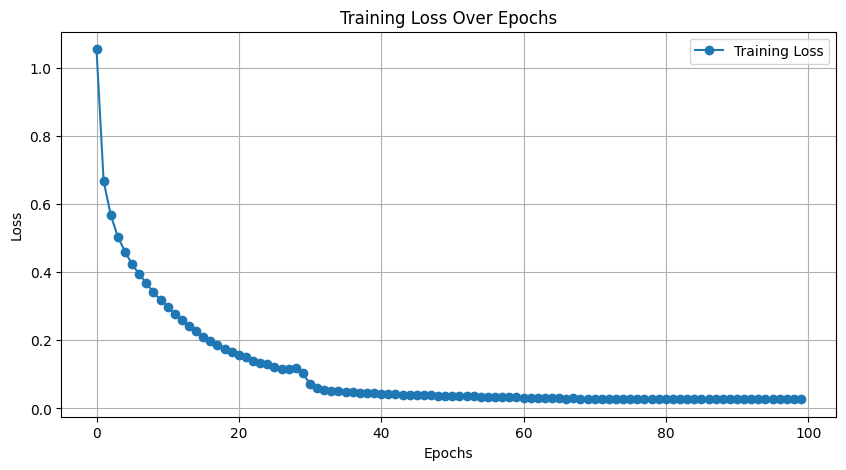

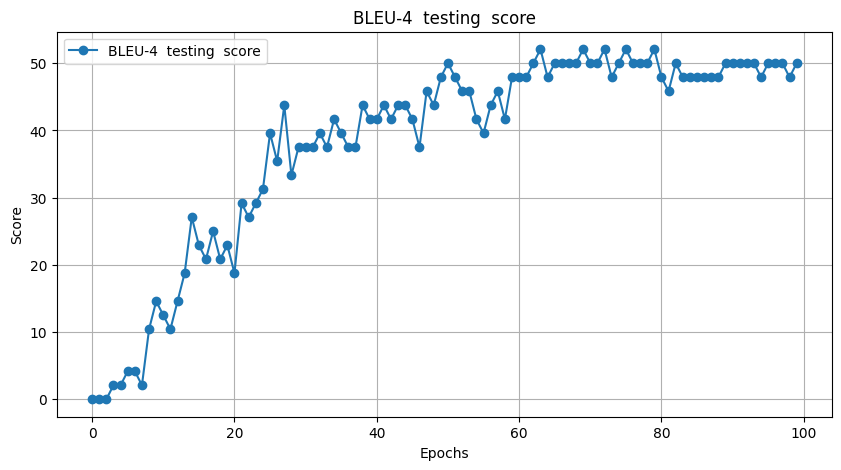

In [90]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 5))
plt.plot(range(epochs), loss_history, marker='o', label='Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss Over Epochs')
plt.grid(True)
plt.legend()
plt.figure(figsize=(10, 5))
plt.plot(range(epochs), blue_scores, marker='o', label='BLEU-4  testing  score')
plt.xlabel('Epochs')
plt.ylabel('Score')
plt.title('BLEU-4  testing  score')
plt.grid(True)
plt.legend()
plt.show()